In [4]:
import pyqg
import pyqg_generative.tools.operators as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def error(x,y):
    return float(np.mean(np.abs(x-y)))

In [25]:
X = np.random.randn(32,32)
Y = np.ones((32,32))
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc').isel(run=0,time=-1,lev=0).q.values.astype('float64')

ratio=2, error=0.12011083914209075
ratio=10, error=0.0020843575504200353
ratio=20, error=0.0008819834335826271
ratio=30, error=0.0005123684497360217


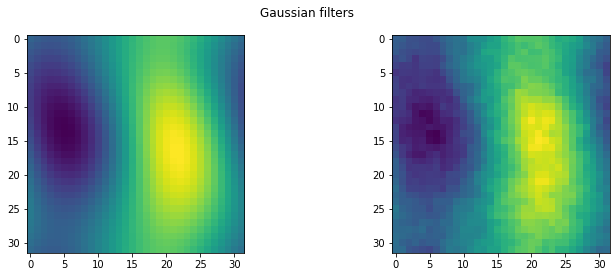

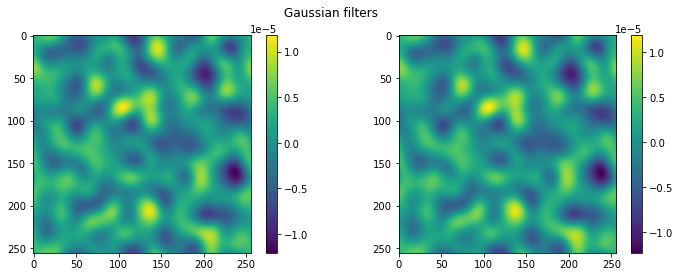

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(X, 30))
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(X, 30))
plt.suptitle('Gaussian filters')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(q, 30)); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(q, 30)); plt.colorbar()
plt.suptitle('Gaussian filters')

for ratio in [2, 10, 20, 30]:
    print(f'ratio={ratio}, error={error(op.gauss_filter(X, ratio), op.gcm_filter(X, ratio))}')

Text(0.5, 0.98, 'Model filter')

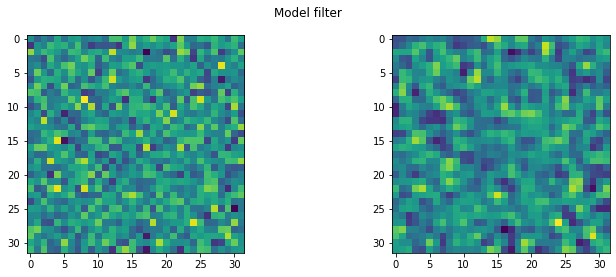

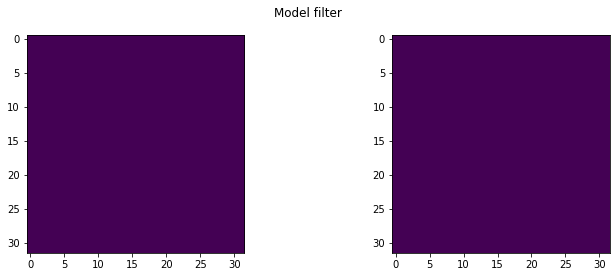

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X)
plt.subplot(1,2,2); plt.imshow(op.model_filter(X))
plt.suptitle('Model filter')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(Y)
plt.subplot(1,2,2); plt.imshow(op.model_filter(Y))
plt.suptitle('Model filter')

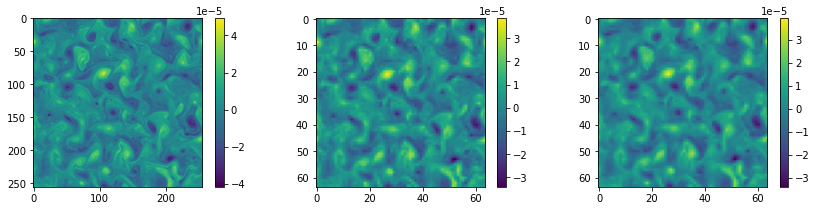

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(q); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(op.cut_off(q,4)); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(op.coarsegrain(q,4)); plt.colorbar()
plt.tight_layout()

# Commutation errors

In [18]:
error(op.gauss_filter(op.cut_off(X, 4), 2), op.cut_off(op.gauss_filter(X, 8), 4)) / np.mean(np.abs(X))

2.6554826868095564e-17

In [19]:
error(op.gcm_filter(op.coarsegrain(X, 4), 2), op.coarsegrain(op.gcm_filter(X, 8), 4)) / np.mean(np.abs(X))

0.06189966673896884

In [20]:
error(op.gcm_filter(op.gauss_filter(X, 3), 3), op.gauss_filter(op.gcm_filter(X, 3), 3)) / np.mean(np.abs(X))

7.600813705709333e-17

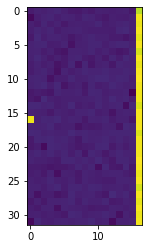

In [26]:
plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))

# Try different formats

In [147]:
op1 = op.gauss_filter

In [199]:
op1(np.stack((X,X)), ratio=4)[0]

array([[-2.81304463e-01, -4.37228406e-01, -3.78549897e-01, ...,
         2.84706677e-02,  1.31252742e-01,  1.46192894e-02],
       [-2.07652630e-01, -3.76465188e-01, -4.25558676e-01, ...,
        -5.03165702e-02,  3.99602166e-02, -5.93879920e-04],
       [-7.58057938e-02, -2.49847112e-01, -3.74445604e-01, ...,
         4.05424057e-02,  6.85685340e-02,  6.34100837e-02],
       ...,
       [ 1.36980906e-02, -3.24710359e-01, -2.50678918e-01, ...,
         5.96969925e-01,  7.33439431e-01,  5.18582627e-01],
       [ 1.00878877e-01, -2.37221788e-01, -1.82636493e-01, ...,
         6.62507280e-01,  9.01798792e-01,  6.54581851e-01],
       [-7.96547753e-02, -3.16004702e-01, -2.46550436e-01, ...,
         3.67541225e-01,  5.49342816e-01,  3.56494686e-01]])

In [200]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc')

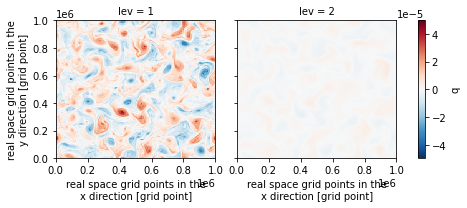

In [204]:
op.model_filter(ds.q.isel(run=0,time=-1), 2).plot(col='lev')